In [8]:
""""
Figaro times collection times script. 
"""
import numpy as np
import pandas as pd
import os
from openpyxl import load_workbook, Workbook
from openpyxl.utils.cell import get_column_letter

perf_path_init = r"/local/scratch/Figaro/figaro-code"
exp_names = ["figaro", "mkl"]
exp_paths = {"figaro": r"comparisons/performance/figaro", "mkl": r"comparisons/performance/python/numpy"}
db_names = ["DBRetailer", "DBFavorita", "DBYelp"]
thread_nums_exp = {"mkl": [48], "figaro": [1, 2, 4, 8, 16, 24, 32, 48]}

join_orders = {"DBFavorita": ["HolidaysRoot", "ItemsRoot", "OilRoot", "SalesRoot", "StoresRoot"],
              "DBYelp": ["BusinessRoot", "CategoryRoot", "CheckinRoot", "HoursRoot", "ReviewRoot", "UserRoot"], 
              "DBRetailer": ["CensusRoot", "InventoryRoot", "ItemRoot", "LocationRoot"]}

start_per = 10
end_per = 100
per_inc = 10

num_measurement = 5

xlsx_name = "time.xlsx"

df_measurement_exp_dbs = {}
for exp_name in exp_names: 
    exp_path = exp_paths[exp_name]
    perf_path = os.path.join(perf_path_init, exp_path)

    for db_name in db_names:
        gather_times_path = os.path.join(perf_path, db_name + xlsx_name)
        print(gather_times_path)
        out_workbook = Workbook()
        out_workbook.remove(out_workbook.active)
        out_sheet = out_workbook.create_sheet("Times")
        df_measurement = pd.DataFrame(columns=join_orders[db_name])
        
        for join_idx, join_order in enumerate(join_orders[db_name]):
            for thread_idx, thread_num in enumerate(thread_nums_exp[exp_name]):
                for db_idx, percent in enumerate(range(start_per, end_per + 1, per_inc)): 
                    db_name_full = "{} {} {}".format(db_name, join_order, thread_num)
                    path_xlsx = os.path.join(perf_path, db_name, join_order+str(thread_num), xlsx_name)
                    print("PATH", path_xlsx)
                    workbook = load_workbook(filename=path_xlsx, data_only=True)
                    sheet = workbook.active
                    row_count = sheet.max_row
                    col_idx = join_idx * thread_nums_exp[exp_name].__len__() + thread_idx + 1
                    col_letter = get_column_letter(col_idx)
                    
                    out_sheet.cell(row=1, column=col_idx).value = db_name_full
                    
                    start_row_idx = 2
                    np_measures = np.zeros(num_measurement)
                    for row_idx_dst in range(start_row_idx, start_row_idx + num_measurement):
                        offset_idx = row_idx_dst - start_row_idx
                        row_idx_src = row_count - num_measurement  + offset_idx
                        val = sheet.cell(row=row_idx_src, column=2).value
                        np_measures[offset_idx] = float(val)
                        #print(idx_shift, db_idx)
                        out_sheet.cell(row=row_idx_dst, column=col_idx).value = val
                    
                    out_sheet.cell(row=start_row_idx + num_measurement, column=col_idx).value = '=AVERAGE({}{}:{}{})'.format(col_letter, start_row_idx + 1, 
                            col_letter,6)

                    time_avg = np.mean(np_measures[1:])
                    df_measurement.at[thread_num, join_order] = time_avg
                
        out_workbook.save(gather_times_path)
        df_measurement_exp_dbs[(exp_name, db_name)] = df_measurement.astype(np.float64)





/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailertime.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot

In [16]:
t = df_measurement_exp_dbs[("figaro", "DBFavorita")]
min_idx_cols = t.idxmin(axis="columns")

print(min_idx_cols[thread_nums_exp["figaro"][-1]])


StoresRoot


    CensusRoot  InventoryRoot    ItemRoot  LocationRoot
1    74.948908     243.816593  196.258810     74.923381
2    46.116488     164.801782  126.946080     47.074211
4    26.186412      93.311124   77.204911     25.961781
8    15.648538      68.645406   44.737076     15.411191
16   11.168841      60.295500   34.020507     11.034114
24    9.782085      67.770459   32.051309      9.802279
32    9.891920      69.052961   28.370486     10.493239
48    9.687545      65.099795   26.400353      9.120898
LocationRoot
    HolidaysRoot   ItemsRoot    OilRoot   SalesRoot  StoresRoot
1     200.561342  213.374533  52.125358  235.110628   51.752857
2     121.023588  127.320735  40.222400  155.173625   38.531615
4      67.088529   71.699466  22.590555   95.376073   25.568010
8      46.564787   45.265902  15.504635   71.697188   13.981276
16     37.278880   34.579824   9.424836   64.637147    9.528099
24     31.291319   30.937327   7.480956   61.745517    7.355615
32     30.944402   33.072448   6.96

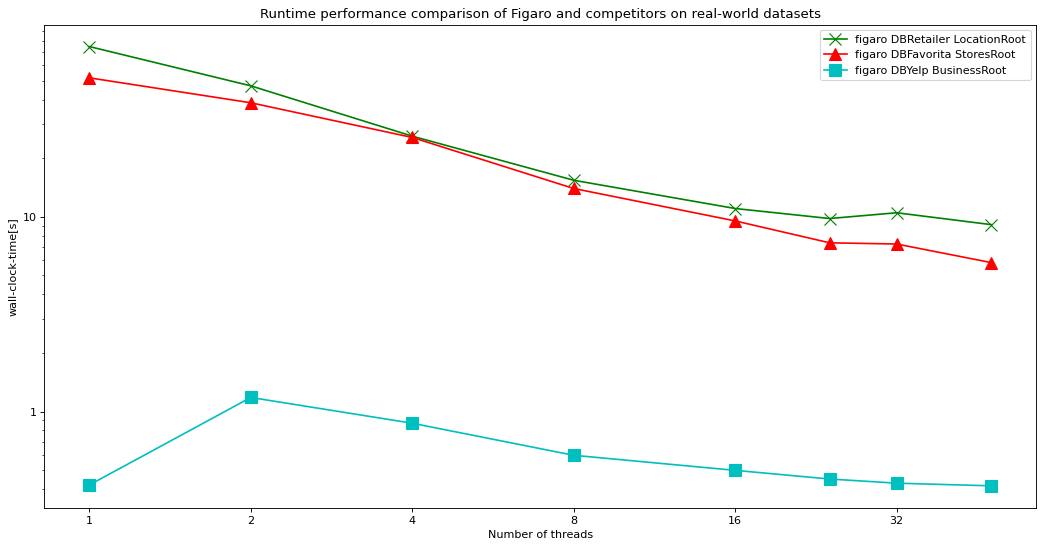

In [64]:
import matplotlib.pyplot as plt
from matplotlib import ticker


plt.figure("name", figsize=(16, 8), dpi=80)
plt.xlabel("Number of threads")
plt.ylabel("wall-clock-time[s]")

plt.title("Runtime performance comparison of Figaro and competitors on real-world datasets")


plt.yscale('log', base=10)
plt.xscale('log', base=2)
#plt.locator_params(axis='x', nbins=6)
#plt.locator_params(axis='y', nbins=20)
db_marker =  {"DBFavorita": "^", "DBYelp": "s", "DBRetailer": "x"}
db_colour =  {"DBFavorita": "r", "DBYelp": "c", "DBRetailer": "g"}
exp_colour = {"figaro": "r", "mkl": "b"}

for exp_name in exp_names:
    if exp_name == "mkl":
        continue
    for db_name in db_names:
        df_measurement = df_measurement_exp_dbs[(exp_name, db_name)]
        print(df_measurement)
        min_idx_cols = df_measurement.idxmin(axis="columns")
        max_num_threads = thread_nums_exp[exp_name][-1]
        min_join_order = min_idx_cols[max_num_threads]

        print(min_idx_cols[thread_nums_exp["figaro"][-1]])
        #for join_order in join_orders[db_name]:
        plt.plot(df_measurement[min_join_order], "-" + db_colour[db_name] + db_marker[db_name], label="{} {} {}".format(exp_name, db_name, min_join_order), markersize=10)

ax = plt.gca()
def myLogFormat(y,pos):
    # Find the number of decimal places required
    decimalplaces = int(np.maximum(-np.log10(y),0))     # =0 for numbers >=1
    # Insert that number into a format string
    formatstring = '{{:.{:1d}f}}'.format(decimalplaces)
    # Return the formatted tick label
    return formatstring.format(y)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))

#formatter = ticker.LogFormatter(base=10, labelOnlyBase=False)
#formatter.set_scientific(True) 
#formatter.set_powerlimits((-1,1)) 
#ax.yaxis.set_major_formatter(formatter) 

formatter = ticker.LogFormatter(base=2)
#formatter.set_scientific(True) 
#formatter.set_powerlimits((0,48)) 
ax.xaxis.set_major_formatter(formatter) 

plt.legend(loc="upper right")




plt.savefig("exp2threads.pdf",bbox_inches='tight')

plt.show()